# GraphNeural Network - Node Classification

### CORA data set-content introduction

- Sample features, labels, adjacency matrix


The data set has a total of 2708 sample points. Each sample point is a scientific paper. All sample points are divided into 8 categories. The categories are 1) Case-based; 2) Genetic algorithm; 3) Neural network; 4) Probabilistic methods; 5) reinforcement learning; 6) rule learning; 7) theory

Each paper is represented by a 1433-dimensional word vector, so each sample point has 1433 features. Each element of the word vector corresponds to a word, and this element has only two values, 0 or 1. Take 0 to indicate that the word corresponding to the element is not in the paper, and 1 to indicate it is in the paper. All the words come from a dictionary with 1433 words.

Each paper cited at least one other paper, or was cited by other papers, that is, there is a connection between the sample points, and no sample point is completely disconnected from other sample points. If the sample points are regarded as points in the graph, then this is a connected graph and there are no isolated points.

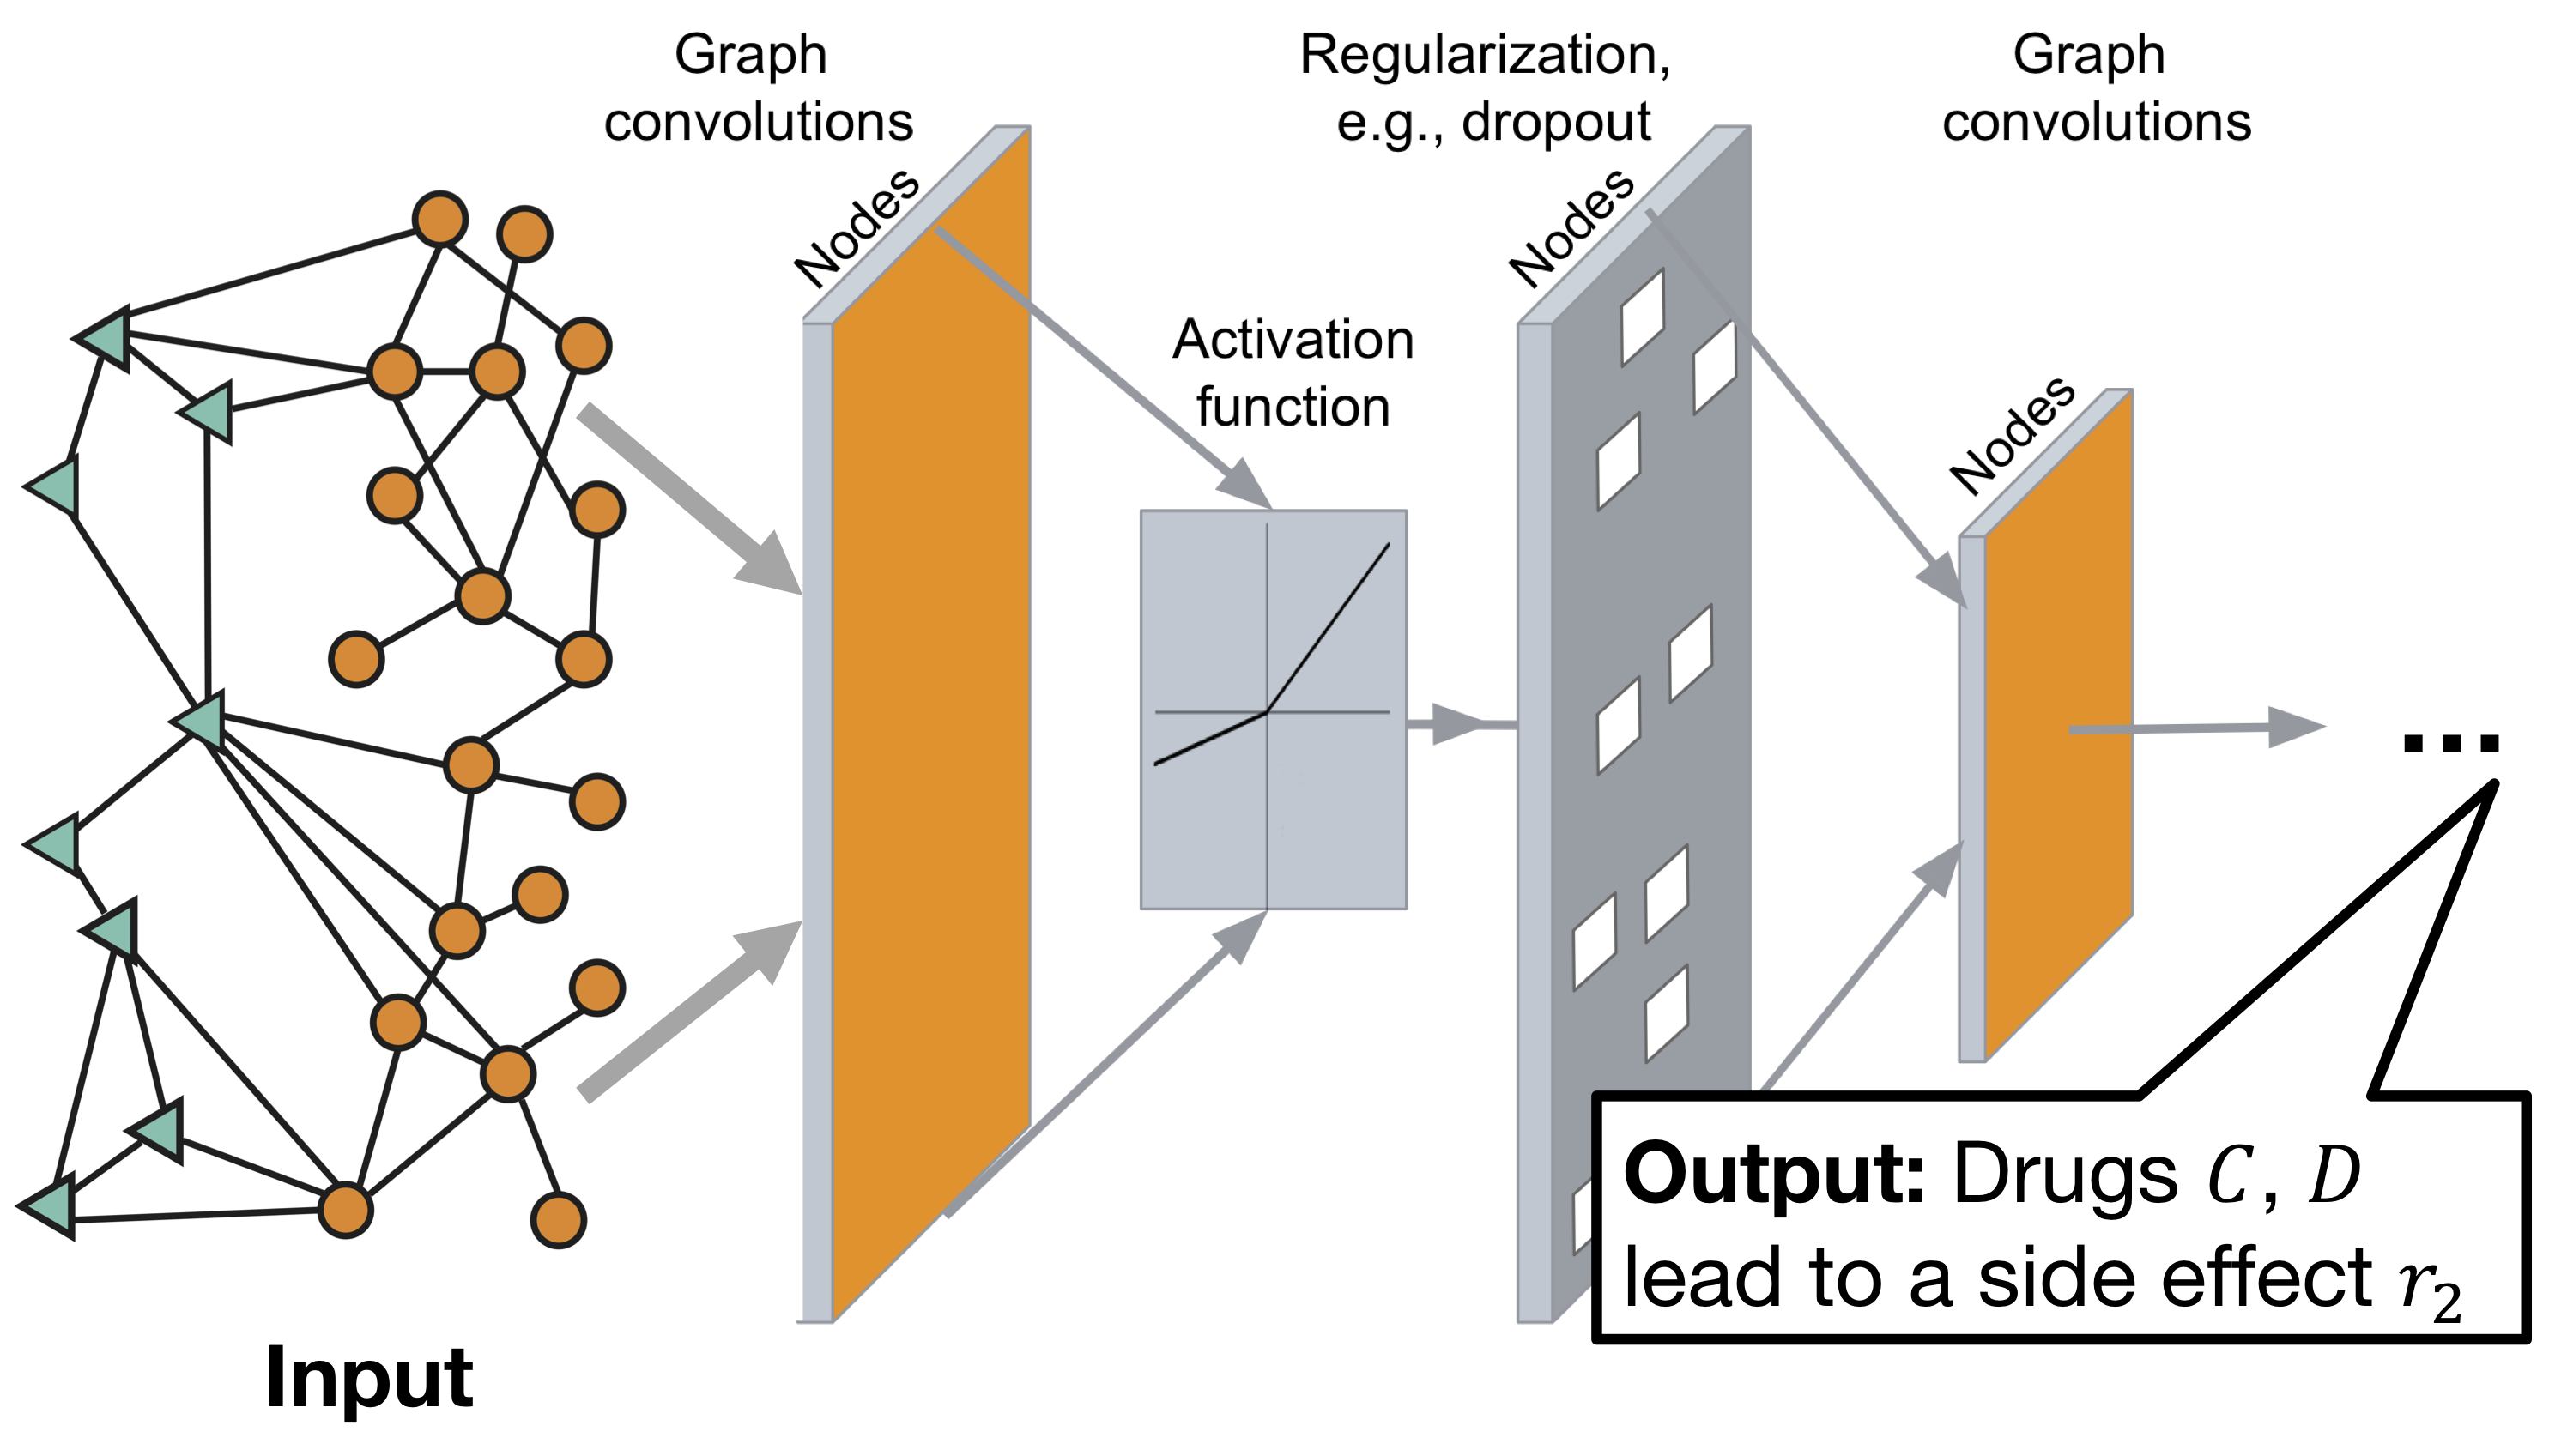

In [1]:
import pandas as pd

In [2]:
# ! wget https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
# ! tar -xf cora.tgz

# ! ls cora

In [3]:
raw_data = pd.read_csv('cora/cora.content',sep = '\t',header = None)

In [4]:
raw_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


- file format

There are three files in the downloaded compressed package, namely cora.cites, cora.content, and README.

README is an introduction to the data set; cora.content is the unique information of all papers; cora.cites is the citation record between papers.

There are 2708 rows in cora.content, and each row represents a sample point, that is, a paper. As shown below, each line consists of three parts, which are the number of the paper, such as 31336; the word vector of the paper, a binary with 1433 bits; and the category of the paper, such as Neural_Networks.

In [5]:
print('Essay id：', raw_data[0][0])

Essay id： 31336


In [6]:
# The bag of words vector of the first paper
raw_data.iloc[0:1, 1:1434]

,1,2,3,4,5,6,7,8,9,10,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [7]:
print('Number of words appearing in the paper:', raw_data.iloc[0:1, 1:1434].sum(1)[0])

Number of words appearing in the paper: 20


In [8]:
print('thesis type:', raw_data.iloc[0, 1434])

thesis type: Neural_Networks


Cora.cites has a total of 5429 lines, each line has two paper numbers, which means that the first numbered paper is written first, and the second numbered paper quotes the first numbered paper. As follows:

In [9]:
# Paper cited data
raw_data_cites = pd.read_csv('cora/cora.cites',sep = '\t',header = None)
raw_data_cites[:10]

,0,1
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
5,35,1103985
6,35,1109199
7,35,1112911
8,35,1113438
9,35,1113831


### Data Preprocess

In [10]:
import numpy as np
import scipy.sparse as sp
import torch

In [11]:
def encode_onehot(labels):
    """
    Turn the label into a onehot vector
    """
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    print(classes_dict)
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

In [12]:
def normalize(mx):
    """
    Normalize sparse matrix by row
    """
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [13]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """
    Convert a sparse matrix from scipy format to torch format
    """
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [14]:
def load_data(path="./cora/", dataset="cora"):
    
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))
    
    ## content data is converted to numpy vector
    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    
    # Take the bag-of-words vector of each paper as the feature vector of each article and store it in a sparse matrix format
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    
    # Take the type of each paper as a label and convert it into a one hot vector
    labels = encode_onehot(idx_features_labels[:, -1])

    # # Take out the id of each paper
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    
    # cites data is converted to numpy vector
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    
    # Map the id in the cites data to the interval [0, 2708]
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    
    # Store the citation relationship between papers in a sparse matrix format
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    
    # Normalize the characteristics of the article
    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))
    
    # Produce the final vector
    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

In [15]:
# Load data, including transformed adjacency matrix, graph network input feature, classification label, training data, verification data, test data
adj, features, labels, idx_train, idx_val, idx_test = load_data()

Loading cora dataset...
{'Case_Based': array([1., 0., 0., 0., 0., 0., 0.]), 'Theory': array([0., 1., 0., 0., 0., 0., 0.]), 'Genetic_Algorithms': array([0., 0., 1., 0., 0., 0., 0.]), 'Neural_Networks': array([0., 0., 0., 1., 0., 0., 0.]), 'Rule_Learning': array([0., 0., 0., 0., 1., 0., 0.]), 'Probabilistic_Methods': array([0., 0., 0., 0., 0., 1., 0.]), 'Reinforcement_Learning': array([0., 0., 0., 0., 0., 0., 1.])}


### Model

 in_features: int
     The size of the image convolution input feature vector, namely $|H^{(l)}|$
     
 out_features: int
     The size of the image convolution output vector, namely $|H^{(l+1)}|$
     
 bias: bool
     Whether to use the offset vector, the default is True, that is, the default is to use the offset vector
     
 weight: Parameter
     Trainable parameters in graph convolution,

In [16]:
import math
import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
     A simple implementation of graph convolution, please refer to the paper https://arxiv.org/abs/1609.02907
     ...
     Attributes
     ----------
     in_features: int
         The size of the image convolution input feature vector, namely $|H^{(l)}|$
     out_features: int
         The size of the image convolution output vector, namely $|H^{(l+1)}|$
     bias: bool
         Whether to use the offset vector, the default is True, that is, the default is to use the offset vector
     weight: Parameter
         Trainable parameters in graph convolution,
        
     Methods
     -------
     __init__(self, in_features, out_features, bias=True)
         The constructor of the graph convolution, defines the size of the input feature, the size of the output vector, whether to use offset, parameters
     reset_parameters(self)
         Initialize the parameters in the graph convolution
     forward(self, input, adj)
         Forward propagation function, input is the feature input, and adj is the transformed adjacency matrix $N(A)=D^{-1}\tilde{A}$. Completing the calculation logic of forward propagation, $N(A) H^{(l)} W^{(l)}$
     __repr__(self)
         Refactored class name expression
     """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        
        # create Weight and Bias trainable parameters
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # standard weight to be uniform
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        # H * W
        support = torch.mm(input, self.weight)
        
        # N(A) * H * W # Addition aggregation by multiplying
        output = torch.spmm(adj, support)
        
        if self.bias is not None:
            # N(A) * H * W + b
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class GCN(nn.Module):
    '''
     Multiple graph convolutional neural network model
     ...
     Attributes
     ----------
     n_feat: int
         The size of the input feature vector of the graph network
     n_hid: int
         The size of the hidden layer, that is, the size of the output vector of the first layer of the convolutional layer
     n_class: int
         Number of classifier categories
     dropout: float
         dropout rate
        
     Methods
     -------
     __init__(self, n_feat, n_hid, n_class, dropout)
         Two-layer graph convolutional neural network constructor, defining the dimension of the input feature, the dimension of the hidden layer, the number of classifier categories, and the dropout rate
     forward(self, x, adj)
         Forward propagation function, x is the input feature of the graph network, adj is the adjacency matrix that has been transformed $N(A)$
     '''
    def __init__(self, n_feat,n_hids, n_class, dropout):
        super(GCN, self).__init__()
        
        # Define the layers of graph convolutional layer
        
        layers_units = [n_feat] +  n_hids
        
        self.graph_layers = nn.ModuleList([GraphConvolution(layers_units[idx],layers_units[idx+1]) for idx in range(len(layers_units)-1)])
        
        self.output_layer = GraphConvolution(layers_units[-1],n_class)

        self.dropout = dropout

    def forward(self, x, adj):
        
        for graph_layer in self.graph_layers:
            x = F.relu(graph_layer(x, adj))
            # dropout
            x = F.dropout(x, self.dropout, training=self.training)
            
        # The output of the final convolutional layer is mapped to the output category dimension
        x = self.output_layer(x, adj)
        
        # Calculate log softmax
        # https://discuss.pytorch.org/t/logsoftmax-vs-softmax/21386/20
        return F.log_softmax(x, dim=1)

In [19]:
def accuracy(output, labels):
    """
    Accuracy calculation method
    """
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [20]:
import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim


# Training hyperparameter configuration
class Args:
    no_cuda = False # Whether to use cuda/gpu
    seed = 42 # Set random seed
    epochs = 200 # number of iterations
    lr = 0.01 # learning rate
    weight_decay = 5e-4 # Learning rate decay
    n_hid = 16 # hidden layer dimension
    dropout = 0.5 # dropout rate

In [21]:
args = Args()
# 是否使用 gpu/cuda
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [22]:
args.cuda

True

In [23]:
# random seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [24]:
input_features = features.shape[1]

In [25]:
model = GCN(n_feat=input_features,
            n_hids=[128,32],
            n_class=labels.max().item() + 1,
            dropout=args.dropout)

In [26]:
# Construct an Adam optimizer,
# The parameters to be optimized are the trainable parameters in the GCN model
# Learning rate is set to args.lr
# Learning rate decay is args.weight_decay
optimizer = optim.Adam(model.parameters(),
                       lr=args.lr, 
                       weight_decay=args.weight_decay)

In [27]:
def accuracy(output, labels):
    """
    Accuracy calculation method
    """
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [28]:
# Model training function, epoch is the number of iterations
def train(epoch):
    # Record the start time of the epoch iteration
    t = time.time()
    # Mark the GCN model is in train mode
    model.train()
    # In each epoch, you need to clear the previously calculated gradient
    optimizer.zero_grad()
    
    """
    Input the graph network input feature and the transformed adjacency matrix adj into the graph convolutional neural network GCN model, and the output is obtained through forward propagation, 
    which is the predicted probability of the classification category
    """
    
    output = model(features, adj)
    
    
    """
    Find the corresponding output probability and label according to the data index of the training set, 
    and then calculate the loss and accuracy
    """
    
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    
    # # Error back propagation
    loss_train.backward()
    
    # The optimizer starts to optimize the trainable parameters in GCN
    optimizer.step()

    
    """Use the validation set data to verify the epoch training results. 
    The verification process needs to close the train mode and open the eval model"""
    
    model.eval()
    
    # # Same forward propagation
    output = model(features, adj)
    """
    Find the corresponding output probability and label according to the data index of the validation set,
    and then calculate the loss and accuracy
    """
    
    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    
    # Print all the results and the time required
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

In [29]:
# Record the start time of model training
t_start = time.time()
# Start iterative training of the GCN model, the number of iterations is set to args.epochs
for epoch in range(args.epochs):
    train(epoch)
    
print("Model training is complete!")
print("Total model training time: {:.4f}s".format(time.time() - t_start))

Epoch: 0001 loss_train: 1.8946 acc_train: 0.1429 loss_val: 1.8451 acc_val: 0.3500 time: 0.0708s
Epoch: 0002 loss_train: 1.8533 acc_train: 0.2929 loss_val: 1.8222 acc_val: 0.3500 time: 0.0608s
Epoch: 0003 loss_train: 1.8224 acc_train: 0.2929 loss_val: 1.8053 acc_val: 0.3500 time: 0.0718s
Epoch: 0004 loss_train: 1.8120 acc_train: 0.2929 loss_val: 1.7915 acc_val: 0.3500 time: 0.0549s
Epoch: 0005 loss_train: 1.7976 acc_train: 0.2929 loss_val: 1.7782 acc_val: 0.3500 time: 0.0568s
Epoch: 0006 loss_train: 1.8053 acc_train: 0.2929 loss_val: 1.7627 acc_val: 0.3500 time: 0.0668s
Epoch: 0007 loss_train: 1.7520 acc_train: 0.3000 loss_val: 1.7477 acc_val: 0.3500 time: 0.0648s
Epoch: 0008 loss_train: 1.7514 acc_train: 0.3000 loss_val: 1.7311 acc_val: 0.3500 time: 0.0628s
Epoch: 0009 loss_train: 1.6994 acc_train: 0.2929 loss_val: 1.7112 acc_val: 0.3500 time: 0.0618s
Epoch: 0010 loss_train: 1.6844 acc_train: 0.2929 loss_val: 1.6893 acc_val: 0.3500 time: 0.0539s
Epoch: 0011 loss_train: 1.6863 acc_train

Epoch: 0088 loss_train: 0.1848 acc_train: 0.9500 loss_val: 0.6482 acc_val: 0.7933 time: 0.0768s
Epoch: 0089 loss_train: 0.1819 acc_train: 0.9571 loss_val: 0.6502 acc_val: 0.7967 time: 0.0838s
Epoch: 0090 loss_train: 0.1690 acc_train: 0.9714 loss_val: 0.6685 acc_val: 0.7800 time: 0.0778s
Epoch: 0091 loss_train: 0.2065 acc_train: 0.9571 loss_val: 0.6906 acc_val: 0.7800 time: 0.0937s
Epoch: 0092 loss_train: 0.1976 acc_train: 0.9643 loss_val: 0.6919 acc_val: 0.7733 time: 0.0608s
Epoch: 0093 loss_train: 0.1578 acc_train: 0.9571 loss_val: 0.6993 acc_val: 0.7800 time: 0.1915s
Epoch: 0094 loss_train: 0.1501 acc_train: 0.9714 loss_val: 0.7214 acc_val: 0.7767 time: 0.1107s
Epoch: 0095 loss_train: 0.1630 acc_train: 0.9714 loss_val: 0.7010 acc_val: 0.7767 time: 0.0997s
Epoch: 0096 loss_train: 0.1751 acc_train: 0.9643 loss_val: 0.6942 acc_val: 0.7633 time: 0.1037s
Epoch: 0097 loss_train: 0.1502 acc_train: 0.9857 loss_val: 0.6980 acc_val: 0.7600 time: 0.0848s
Epoch: 0098 loss_train: 0.1865 acc_train

Epoch: 0177 loss_train: 0.1031 acc_train: 0.9714 loss_val: 0.8494 acc_val: 0.7633 time: 0.0758s
Epoch: 0178 loss_train: 0.1206 acc_train: 0.9571 loss_val: 0.8226 acc_val: 0.7733 time: 0.0578s
Epoch: 0179 loss_train: 0.1569 acc_train: 0.9571 loss_val: 0.8298 acc_val: 0.7667 time: 0.0678s
Epoch: 0180 loss_train: 0.1795 acc_train: 0.9357 loss_val: 0.8154 acc_val: 0.7733 time: 0.0638s
Epoch: 0181 loss_train: 0.1015 acc_train: 0.9786 loss_val: 0.8574 acc_val: 0.7533 time: 0.0568s
Epoch: 0182 loss_train: 0.0870 acc_train: 0.9857 loss_val: 0.8678 acc_val: 0.7467 time: 0.0509s
Epoch: 0183 loss_train: 0.1111 acc_train: 0.9714 loss_val: 0.8149 acc_val: 0.7600 time: 0.0539s
Epoch: 0184 loss_train: 0.1233 acc_train: 0.9857 loss_val: 0.7541 acc_val: 0.7767 time: 0.0568s
Epoch: 0185 loss_train: 0.1781 acc_train: 0.9571 loss_val: 0.7365 acc_val: 0.7733 time: 0.0828s
Epoch: 0186 loss_train: 0.1042 acc_train: 0.9786 loss_val: 0.7546 acc_val: 0.7600 time: 0.0898s
Epoch: 0187 loss_train: 0.1061 acc_train

In [30]:
# Model test function
def test():
    # First mark the model as eval mode
    model.eval()
    """
    # Input the graph network input feature and the transformed adjacency matrix adj into the two-layer graph convolutional neural network GCN model, 
    and the output is obtained through forward propagation, which is the predicted probability of the classification category
    """
    output = model(features, adj)
    """
    Find the corresponding output probability and label according to the data index of the test set, 
    and then calculate the loss and accuracy
    """
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    
test()

Test set results: loss= 0.6823 accuracy= 0.7930
